In [1]:
# pre requisites
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install umap-learn

In [2]:
import numpy
import matplotlib.pyplot as plt
import umap

In [3]:
# extract input embeddings as input.txt
# python extract_embeddings_input.py --model TinyLlama/TinyLlama-1.1B-Chat-v1.0 --tokenizer TinyLlama/TinyLlama-1.1B-Chat-v1.0 --prompt "I like to listen to music on my" --output_prefix radio/input
#
# extract embeddings from the hidden layers
# python extract_embeddings_hidden_all.py --model TinyLlama/TinyLlama-1.1B-Chat-v1.0 --tokenizer TinyLlama/TinyLlama-1.1B-Chat-v1.0 --prompt "I like to listen to music on my" --output_prefix radio/embeddings
#

# Define locations and tokens
words= [ "<s>", "I", "like", "to", "listen", "to", "music", "on", "my"]
skip_first_token=1 # skip showing the first token e.g. "<s>"
inputfolder = "radio/"
png_prefix = "radio-images/single-new"

# Load embeddings
#dimensions = numpy.empty((0, 2048))   # replace below if don't want to load initial input embeddings from extract_embeddings_input.py
dimensions = numpy.loadtxt(inputfolder+"input.txt")
print(dimensions.shape)

# Load embeddings from each hidden layer
for layer in range(0,23):
    layer_embeddings = numpy.loadtxt(inputfolder+"embeddings-"+str(layer)+".txt")
    dimensions = numpy.vstack((dimensions,layer_embeddings))

# Apply umap to all embeddings from all layers
data = numpy.array(dimensions)
umap_model = umap.UMAP(n_components=2, random_state=42)
data_2d = umap_model.fit_transform(data)

(9, 2048)


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
## Output embeddings
# first 11 are <s> and then 10 nearest identified using print_output.py 
# 12 onwards are random words taken from the output embeddings vocab
# final word is the nearest identified by print_output.py
#
# python print_output_embeddings.py --model TinyLlama/TinyLlama-1.1B-Chat-v1.0 --tokenizer TinyLlama/TinyLlama-1.1B-Chat-v1.0 --prompt "way car own computer walk morning daily smart head radio Days Change Product Cat one redirect sent Font Alex weak dash destroy static Should Digital gender bag patch circle course Dictionary toggle cancel Free fish phone"
output_words = ["<s>", "way", "car", "own", "computer", "walk", "morning", "daily", "smart", "head", "radio", "Days", "Change", "Product", "Cat", "one", "redirect", "sent", "Font", "Alex", "weak", "dash", "destroy", "static", "Should", "Digital", "gender", "bag", "patch", "circle", "course", "Dictionary", "toggle", "cancel", "Free", "fish", "phone"]
output_dimensions = numpy.loadtxt("outputembeddings.txt")

output_data = numpy.array(output_dimensions)
# scale up to match same range as attention layer outputs - calculated on the average proportion scale up of the final word embeddings from 1st layer to final
output_data = output_data * 680

# map positions of each token to the dimension space of the attention layer outputs
output_data_2d = umap_model.transform(output_data) 

/tmp/ipykernel_3165/3348317177.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


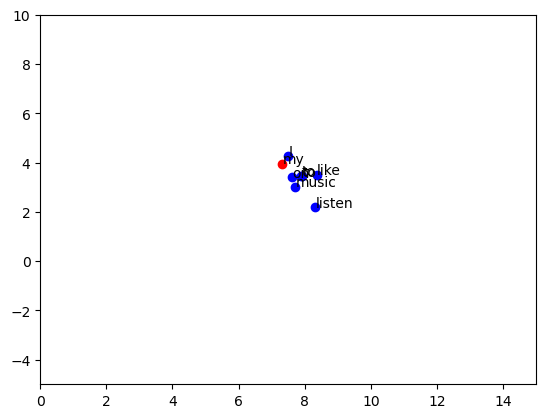

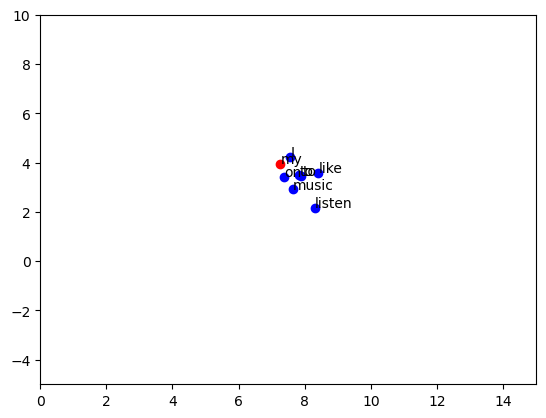

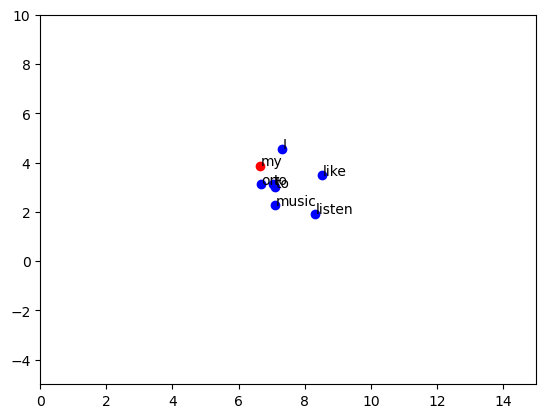

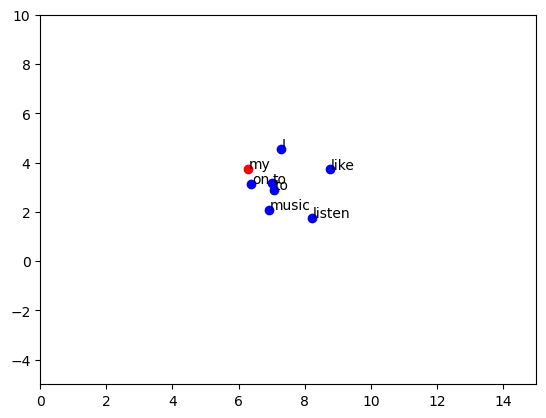

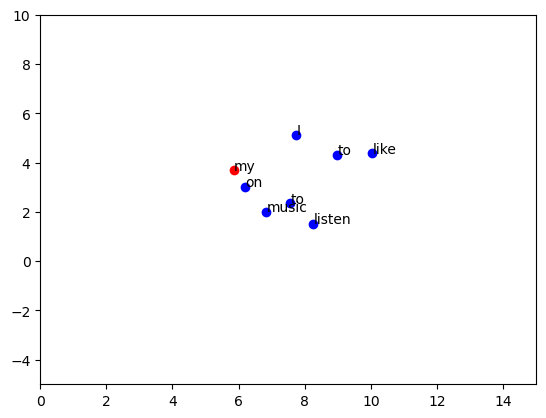

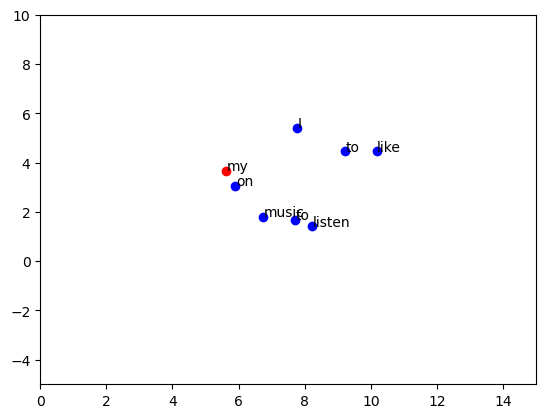

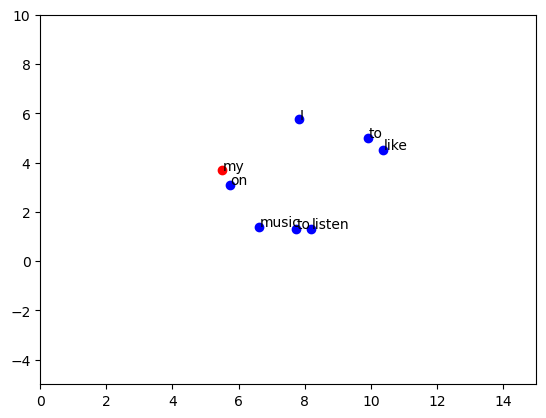

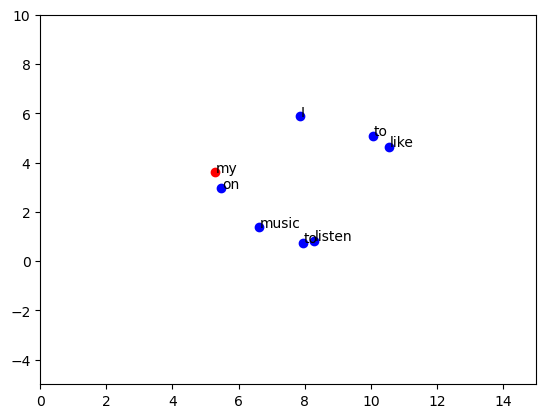

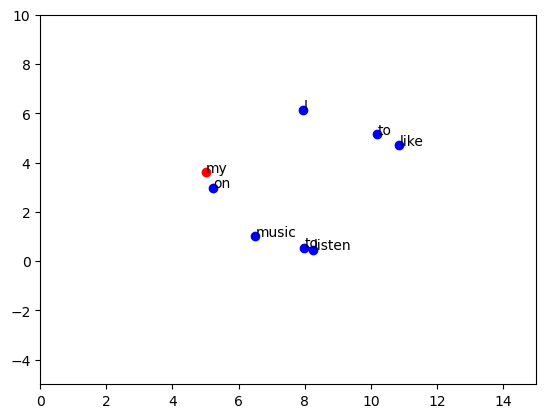

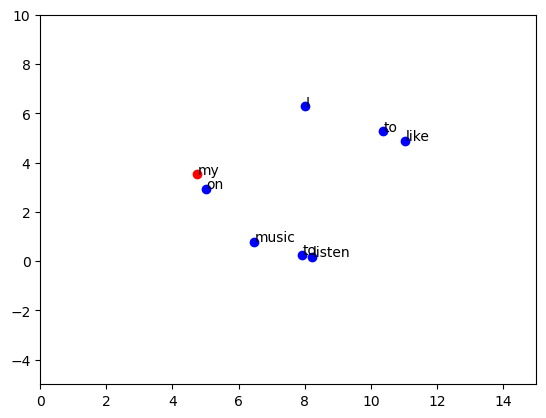

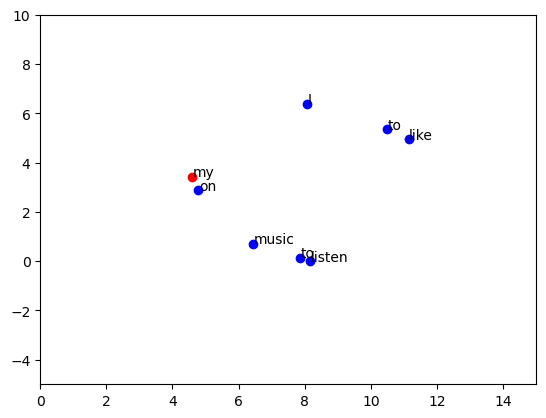

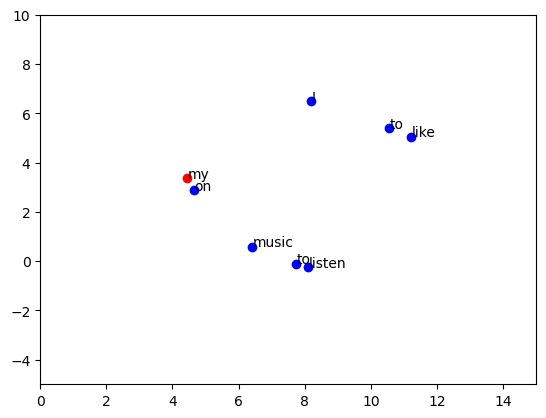

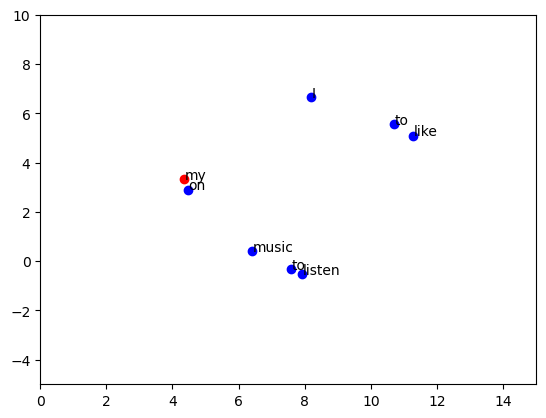

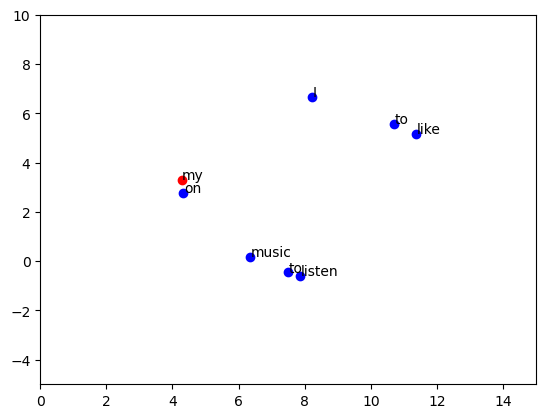

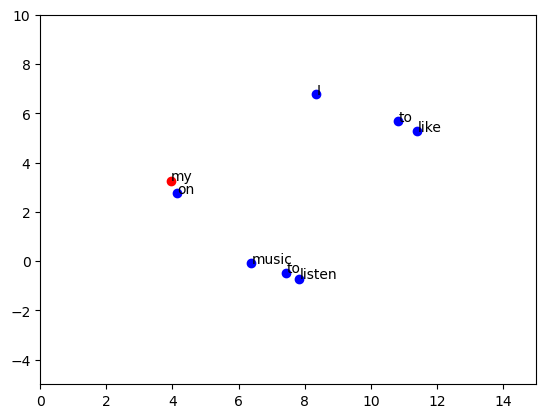

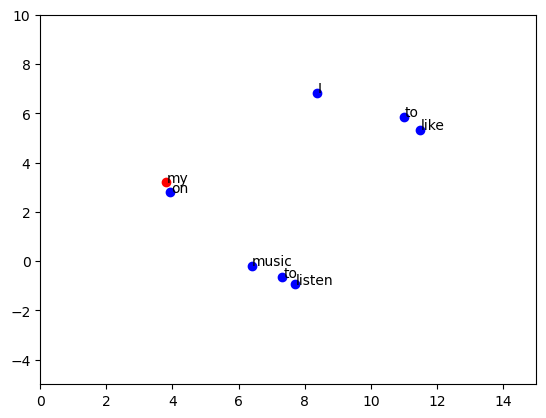

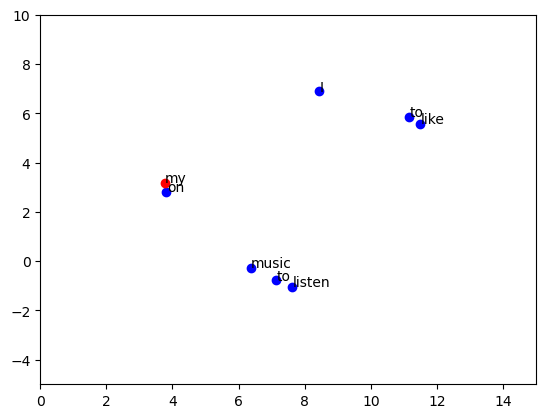

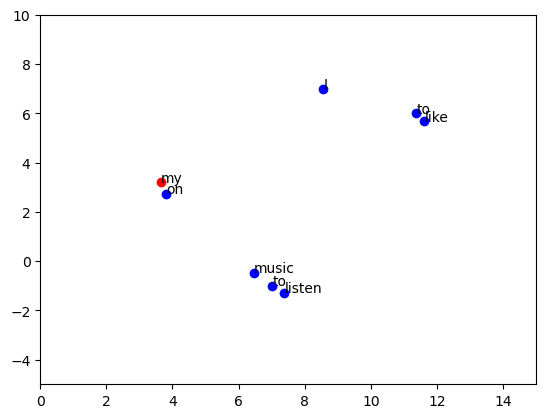

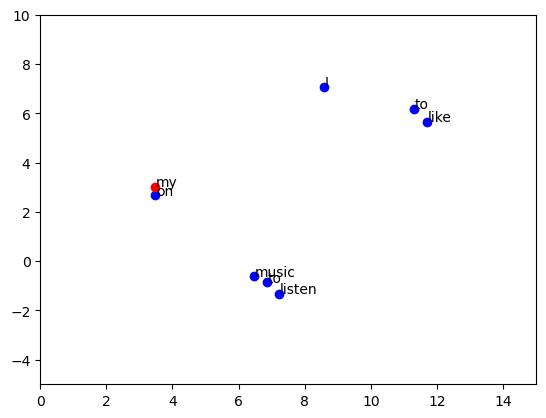

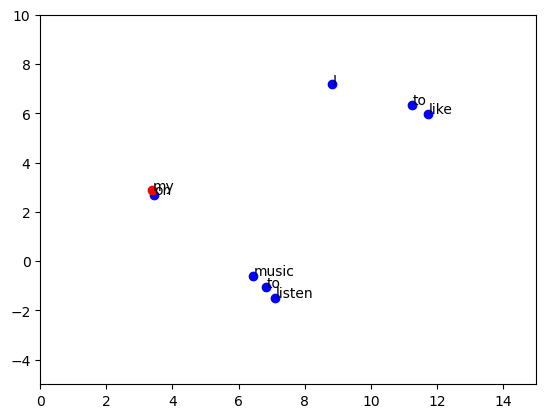

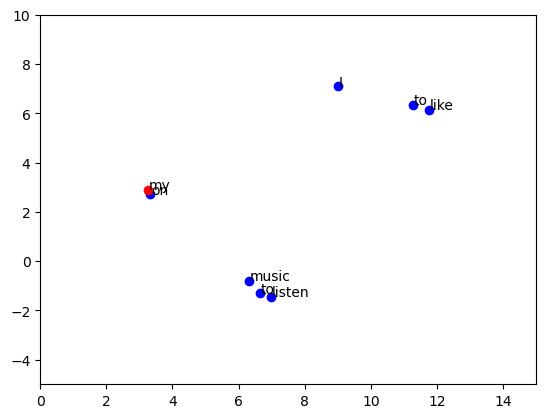

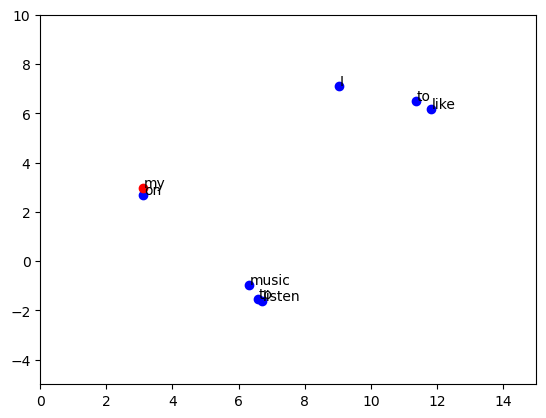

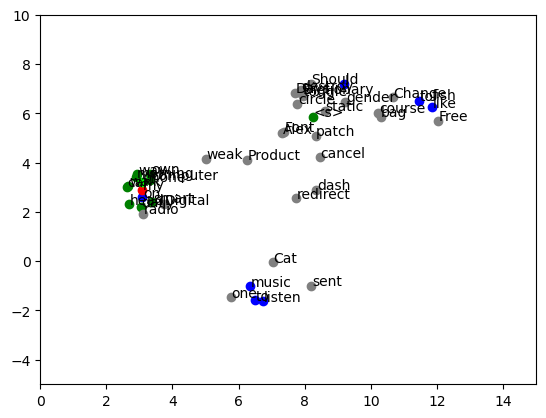

In [5]:
## Plot and save graphs
for layer in range(0,23):
    
    fig, ax = plt.subplots()
    # full view
    plt.xlim(-0, 15)
    plt.ylim(-5, 10)
    # zoom view
    #plt.xlim(2, 4)
    #plt.ylim(1.5, 4)
    
    # calc this start and end tokens for this layer - use skip_first_token = 1 or = 0 if you don't want <s>
    layer_start_index = (layer * len(words))+skip_first_token
    layer_end_index = layer_start_index + len(words) -skip_first_token

    # Plot embedding positions
    ax.scatter(data_2d[layer_start_index:layer_end_index-1,0], data_2d[layer_start_index:layer_end_index-1,1],color="blue")
    ax.scatter(data_2d[layer_end_index-1:layer_end_index,0], data_2d[layer_end_index-1:layer_end_index,1],color="red")
    
    # label tokens 
    posOffset=0.02
    for i,pos in enumerate(data_2d[layer_start_index:layer_end_index]):
        ax.annotate(words[i+skip_first_token], (pos[0], pos[1]), xytext=(pos[0]+posOffset, pos[1]+posOffset),)

    # plot output embeddings - first 10 nearest identified using print_output.py 
    if layer == 22:
        # plot output embeddings for the near words
        out_start_index = 0
        out_end_index = 10
        ax.scatter(output_data_2d[0:out_end_index,0], output_data_2d[0:out_end_index,1], color="green")

        # plot output embeddings for the random words
        out_start_index = out_end_index
        out_end_index = len(output_data_2d)-2
        ax.scatter(output_data_2d[out_start_index:out_end_index,0], output_data_2d[out_start_index:out_end_index,1], color="grey")

        # plot output embeddings for the nearest word
        ax.scatter(output_data_2d[len(output_data_2d)-1:len(output_data_2d)-0,0], output_data_2d[len(output_data_2d)-1:len(output_data_2d)-0,1], color="lime")

        for i,pos in enumerate(output_data_2d[0:len(output_data_2d)]):
            ax.annotate(output_words[i], (pos[0], pos[1]), xytext=(pos[0]+posOffset, pos[1]+posOffset),)
            
        # save plot of last layer
        #plt.savefig(png_prefix+"-"+str(layer)+"-highlight.png")
        #plt.savefig(png_prefix+"-"+str(layer)+"-output-unscaled.png")
        #plt.savefig(png_prefix+"-"+str(layer)+"-output-zoom.png")
        #plt.savefig(png_prefix+"-"+str(layer)+"-output-zoom-next.png")

    # save plot of each layer
    #plt.savefig(png_prefix+"-"+str(layer)+".png")